In [173]:
import numpy as np
import pandas as pd
import math
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_validate

from typing import Dict, List, Tuple

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

# ДЗ №2

## EDA

Название целевой переменной - IsFraud.

In [3]:
train = pd.read_csv("assignment_train.csv")
test = pd.read_csv("assignment_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


In [6]:
train.iloc[:,:20].head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0


In [7]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


In [8]:
test.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,7.500000e+04,75000.000000,7.500000e+04,75000.000000,75000.000000,74005.000000,75000.000000,74589.000000,64490.000000,64490.000000,...,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000,24387.000000
mean,3.099500e+06,0.025973,2.279529e+06,128.028591,9831.878667,371.307695,154.075347,199.892169,291.440564,86.974725,...,0.159060,105.575307,131.765079,119.110755,11.564440,21.261696,16.245663,36.206626,42.026613,38.234797
std,2.165078e+04,0.159057,4.140176e+05,193.315818,4908.219772,159.001973,12.295349,40.927724,100.732324,1.704298,...,0.764107,730.361658,854.615865,768.778641,102.634158,134.484367,119.260027,339.409687,378.479522,345.706813
min,3.062000e+06,0.000000,1.643492e+06,1.000000,1006.000000,100.000000,100.000000,100.000000,110.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.080750e+06,0.000000,1.950398e+06,45.000000,6019.000000,220.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.099500e+06,0.000000,2.187586e+06,75.000000,9633.000000,390.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.118249e+06,0.000000,2.595982e+06,131.000000,14223.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.136999e+06,1.000000,3.093408e+06,5094.950000,18396.000000,600.000000,231.000000,237.000000,536.000000,102.000000,...,15.000000,20750.000000,22500.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [9]:
col_number_view = 20
for it in range(math.ceil(train.shape[1]/col_number_view)):
    print(train.iloc[:,it*col_number_view:(it+1)*col_number_view].head(5))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3  
0           NaN           NaN  1.0  1.0  0.0 

4   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  
   V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V258  V259  V260  V261  V262  V263  V264  V265  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   1.0   1.0   1.0   1.0   1.0   0.0   0.0   0.0  
   V266  V267  V268  V269  V270  V271  V272  V273  V274  V275  V276  V277  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN

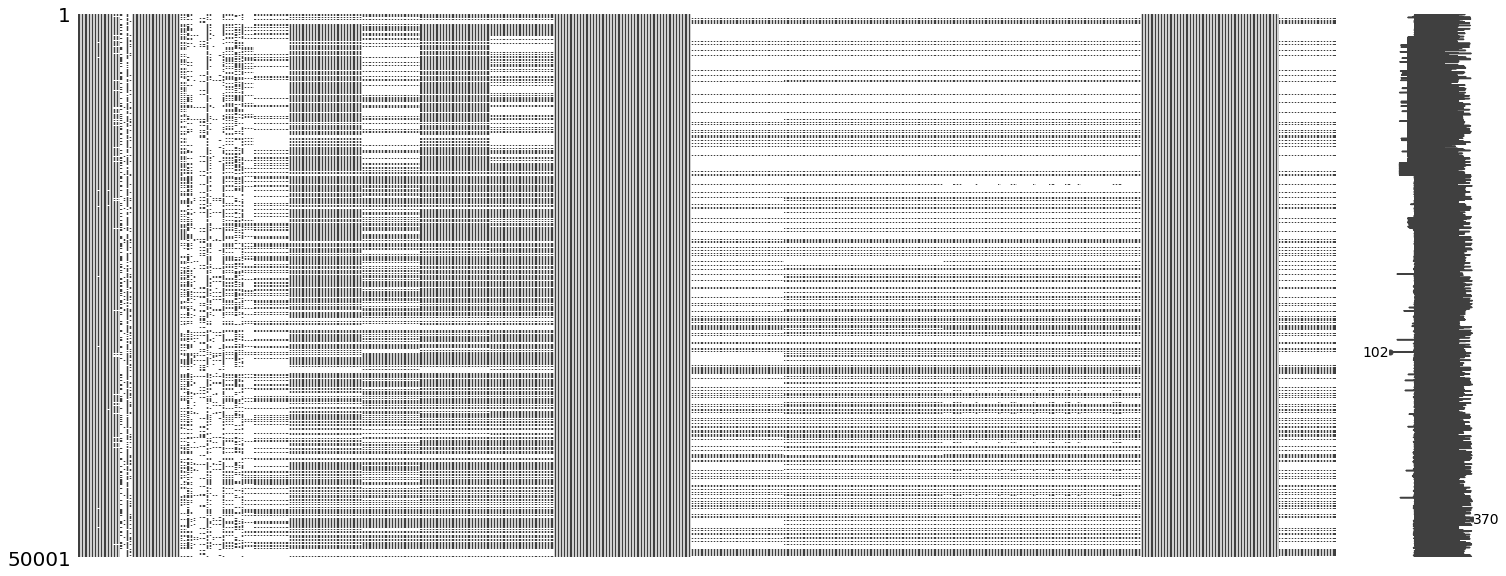

In [10]:
msno.matrix(train)

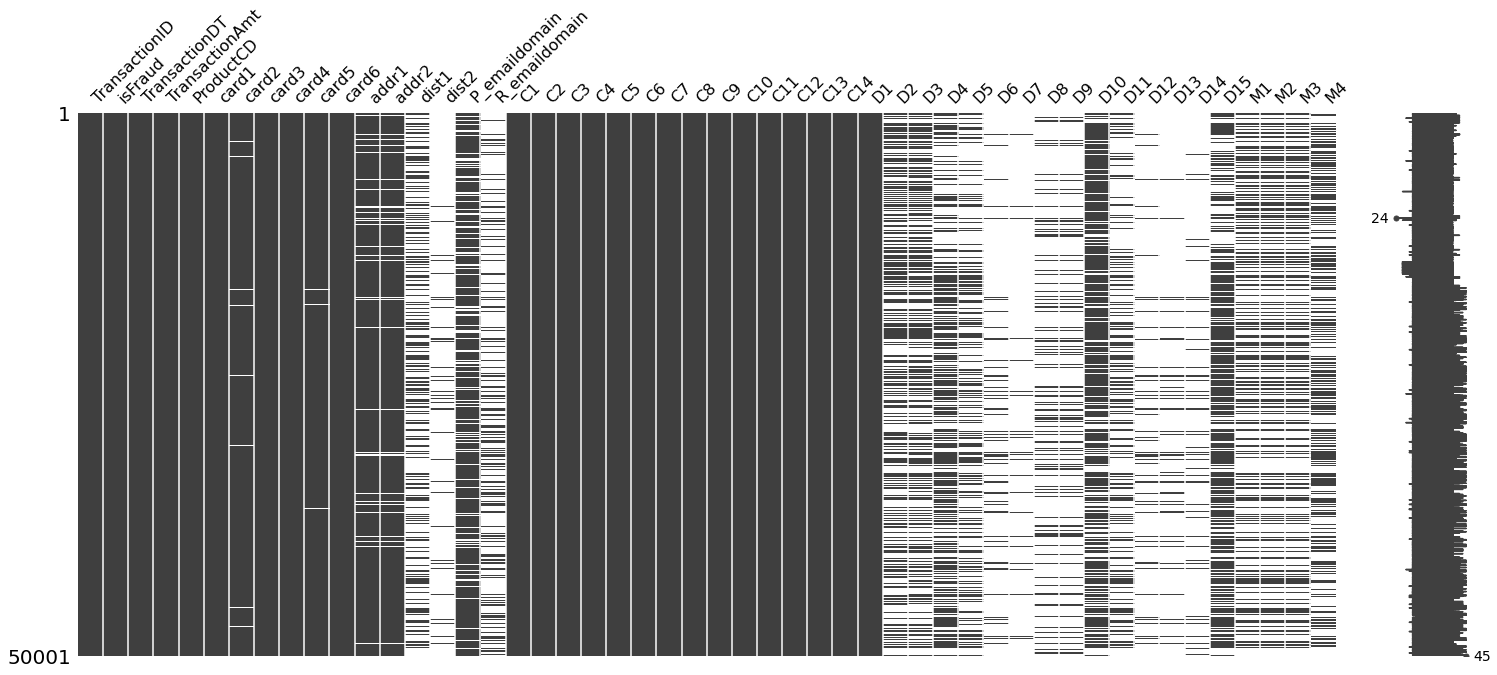

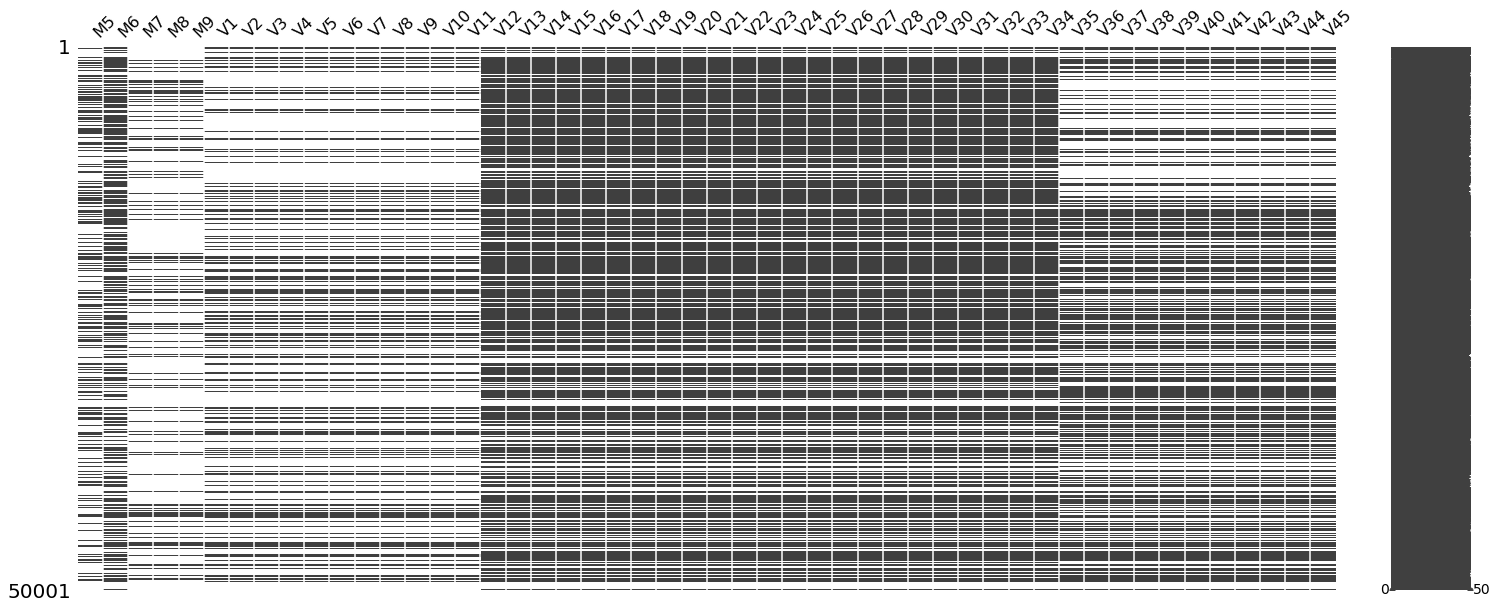

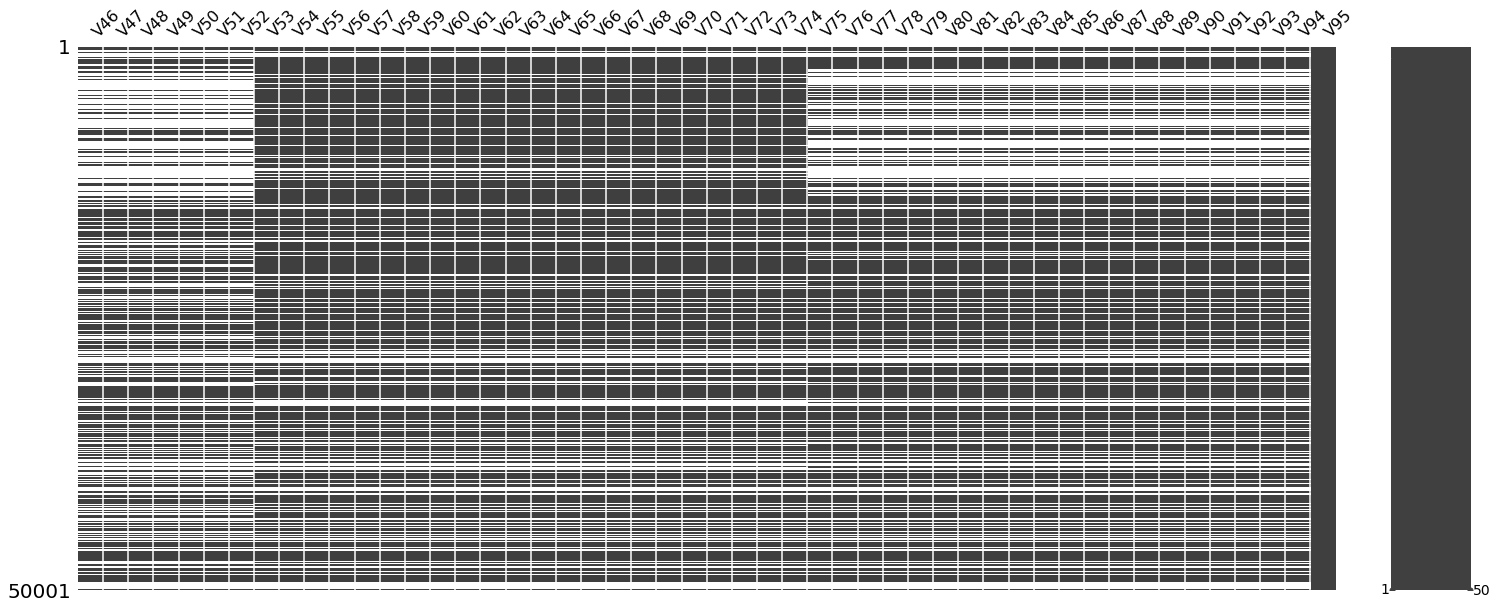

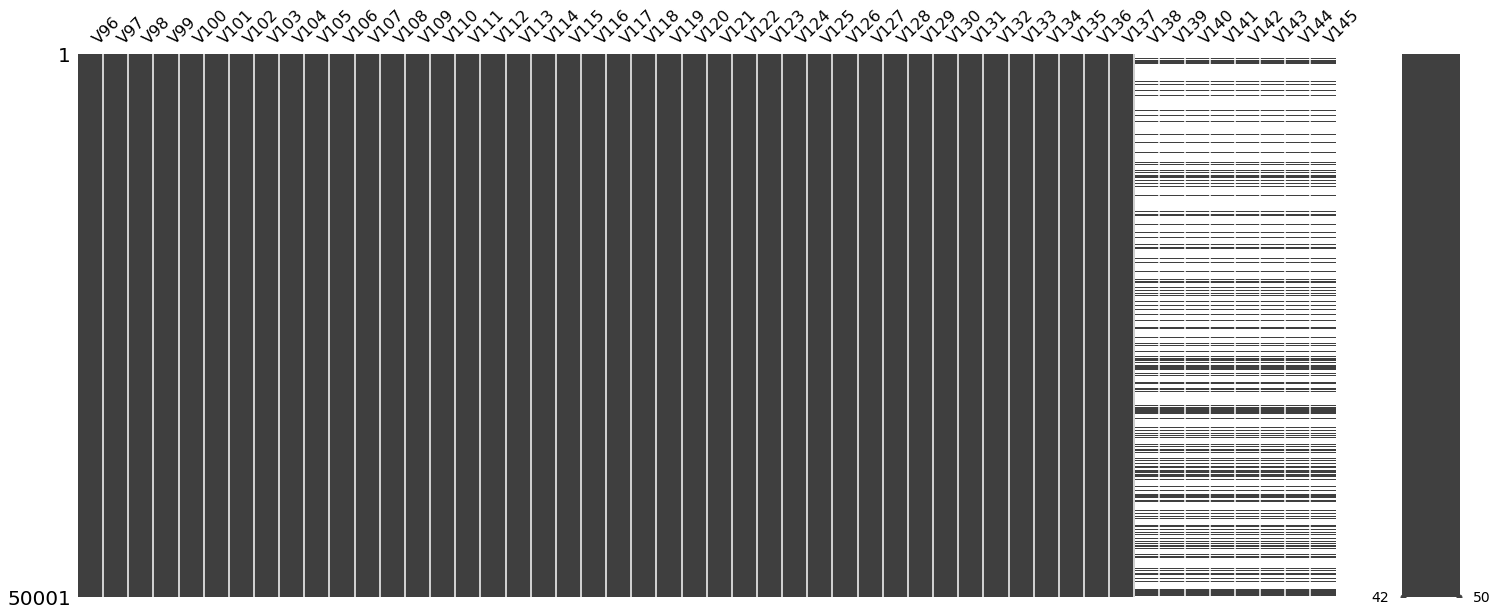

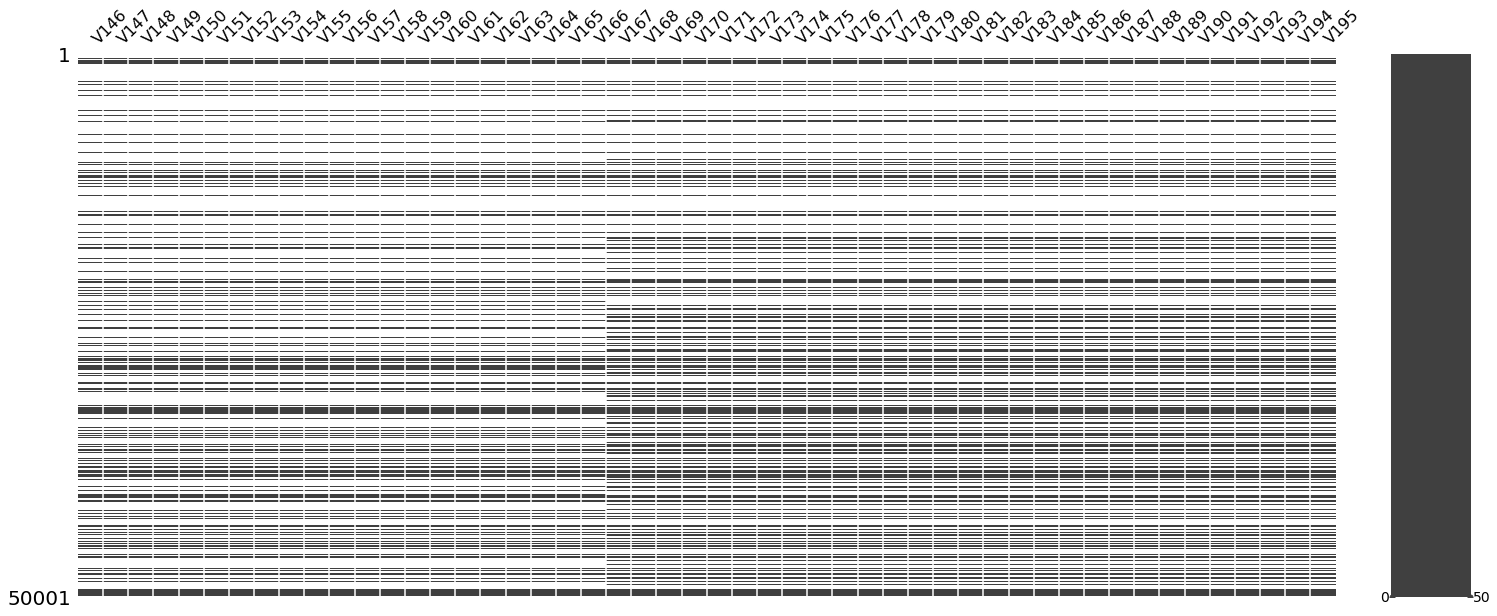

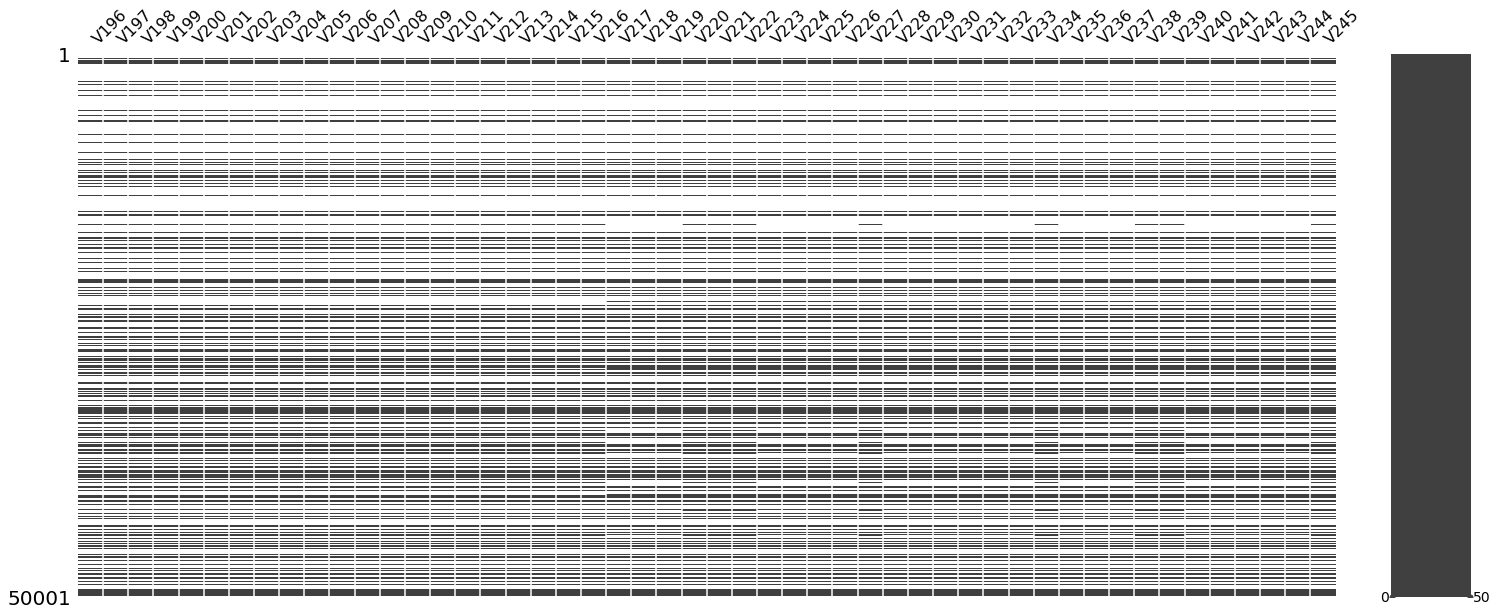

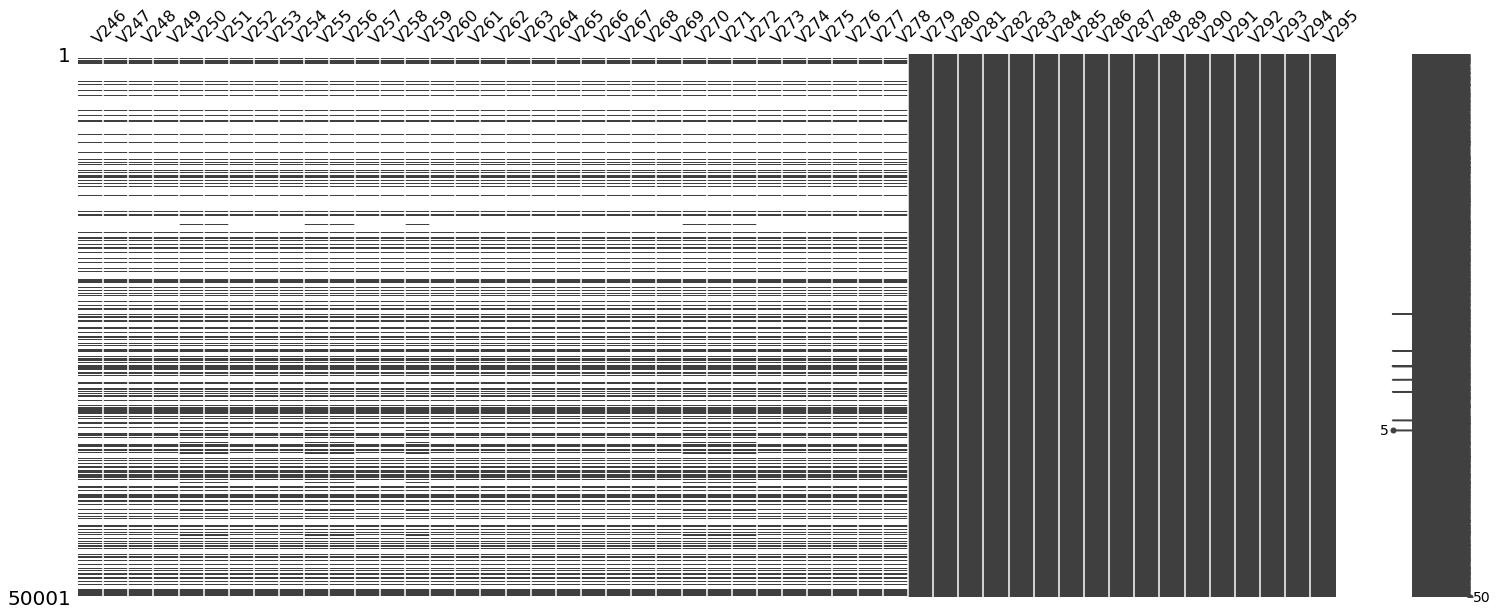

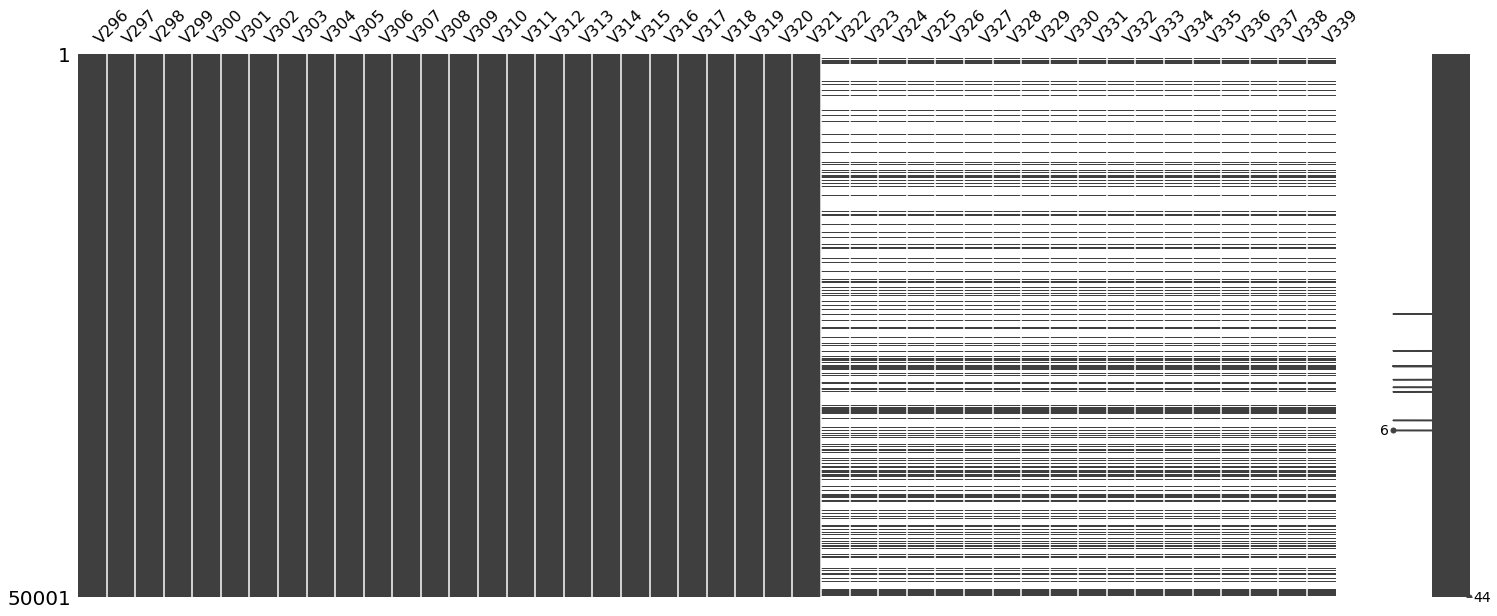

In [11]:
col_number_view = math.ceil(train.shape[1]/8)
for it in range(8):
    msno.matrix(train.iloc[:,it*col_number_view:(it+1)*col_number_view])

In [12]:
nan_cnt = train.isna().sum()
col_less_nan_list = nan_cnt[nan_cnt < train.shape[0]/3].index
col_less_nan_list

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=182)

In [13]:
train_crop = train[col_less_nan_list].copy()
test_crop = test[col_less_nan_list].copy()

In [14]:
train_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 182 entries, TransactionID to V321
dtypes: float64(174), int64(4), object(4)
memory usage: 69.4+ MB


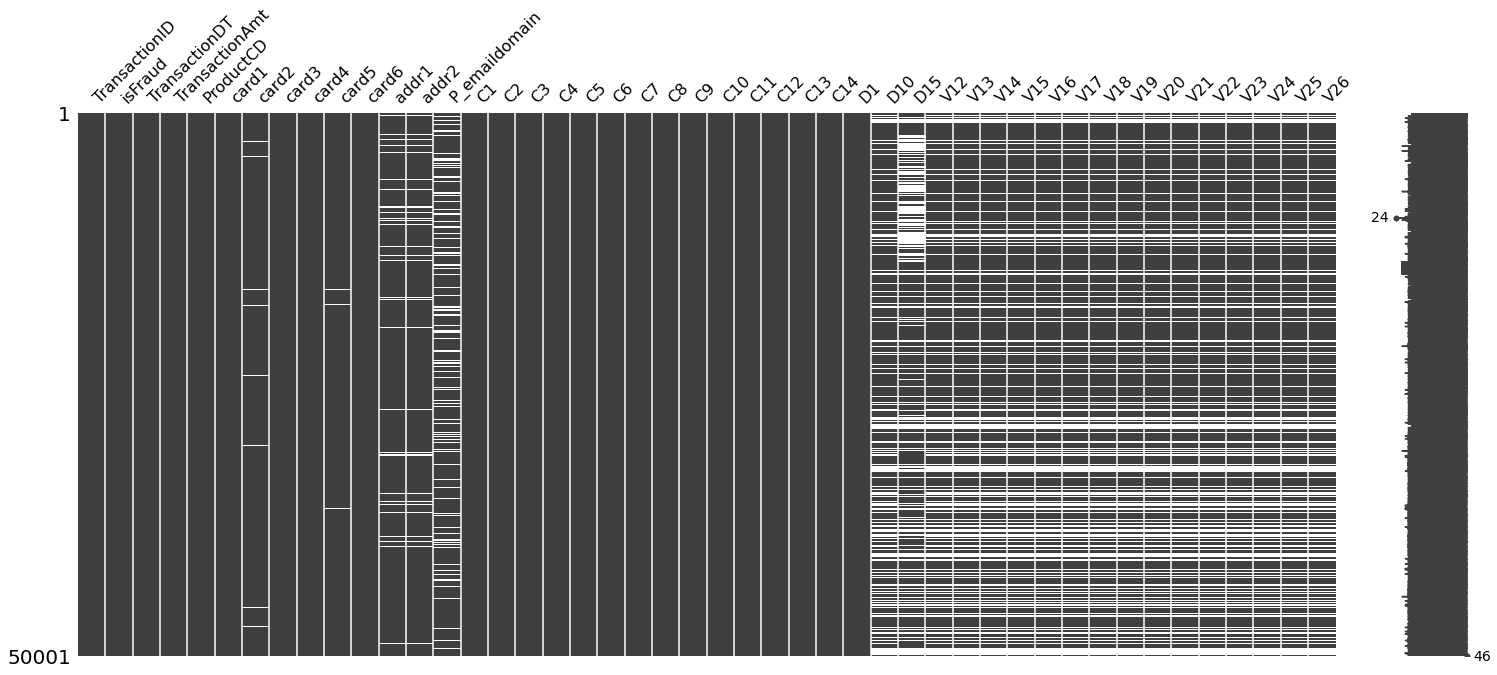

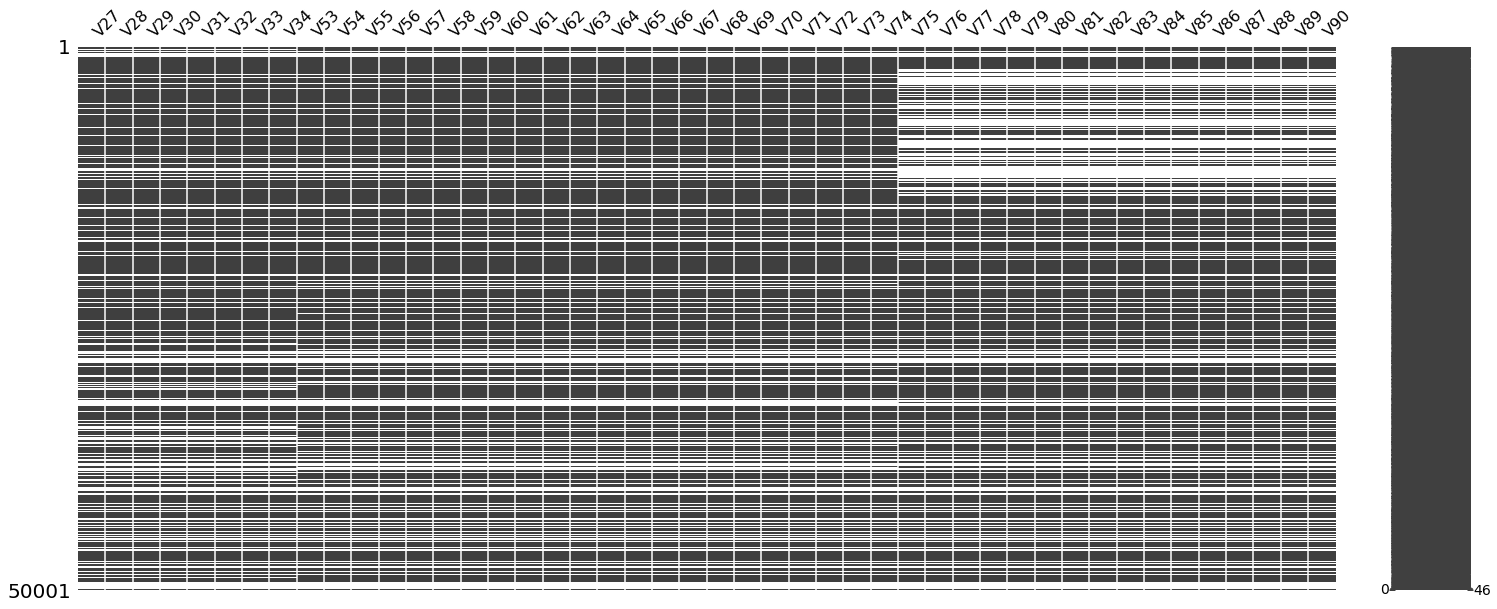

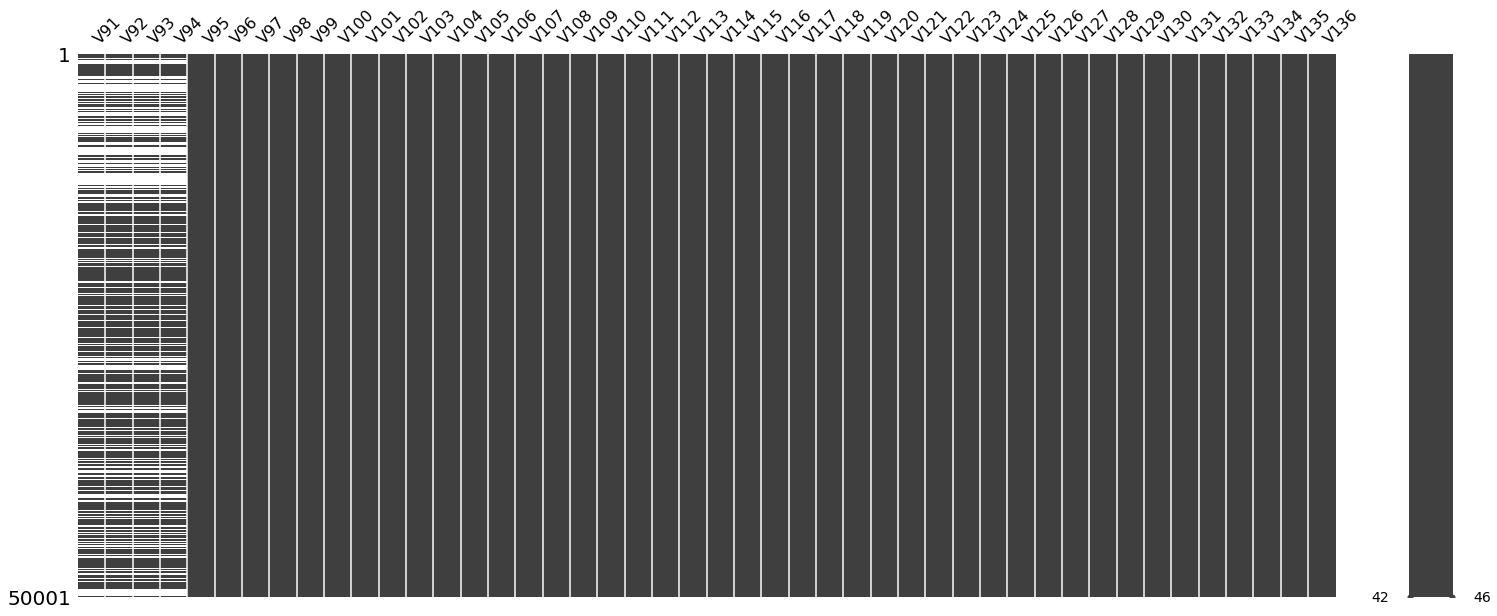

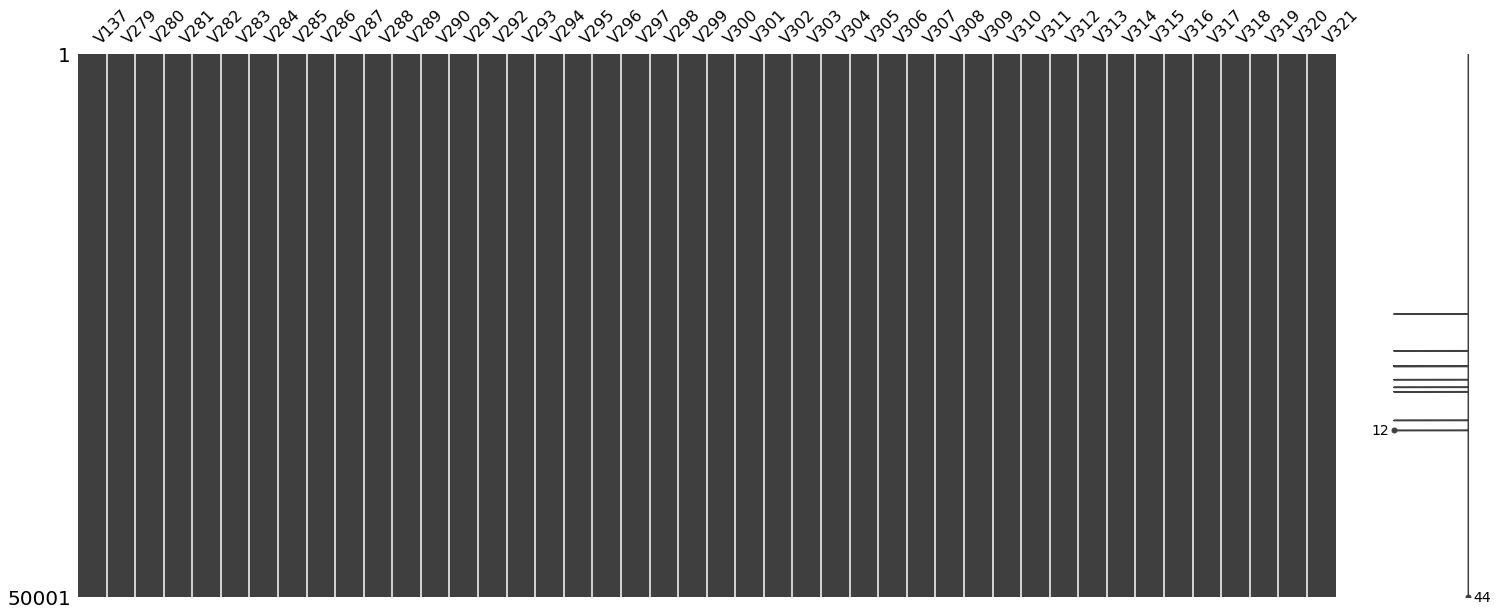

In [15]:
col_number_view = math.ceil(train_crop.shape[1]/4)
for it in range(4):
    msno.matrix(train_crop.iloc[:,it*col_number_view:(it+1)*col_number_view])

In [16]:
object_features = train_crop.select_dtypes(include=[np.object])
print(f"count of object_features {object_features.shape[1]}")

object_features.columns

count of object_features 4


Index(['ProductCD', 'card4', 'card6', 'P_emaildomain'], dtype='object')

In [17]:
list(object_features.columns)

['ProductCD', 'card4', 'card6', 'P_emaildomain']

In [18]:
train_crop[list(object_features.columns)] = train_crop[list(object_features.columns)].fillna("")

In [19]:
numerical_features = train_crop.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 178


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=178)

In [20]:
train_crop[list(numerical_features.columns)] = train_crop[list(numerical_features.columns)].fillna(-1)

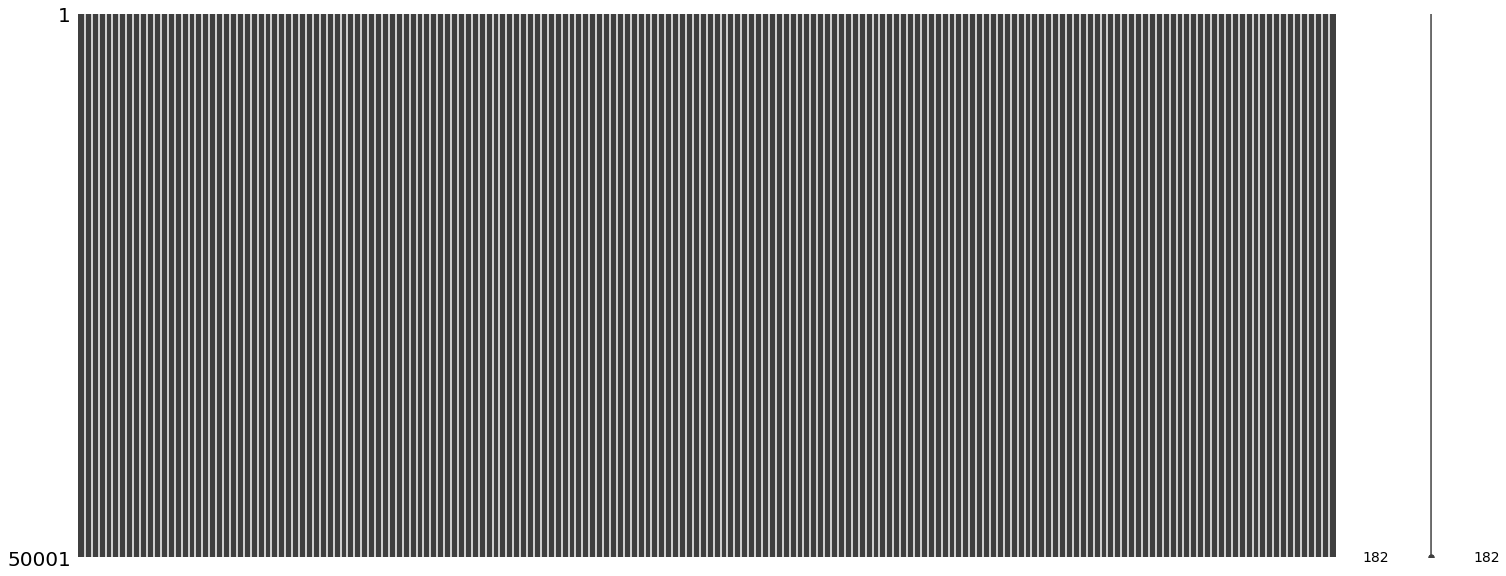

In [21]:
msno.matrix(train_crop)

In [22]:
test_crop[list(object_features.columns)] = test_crop[list(object_features.columns)].fillna("")

In [23]:
test_crop[list(numerical_features.columns)] = test_crop[list(numerical_features.columns)].fillna(-1)

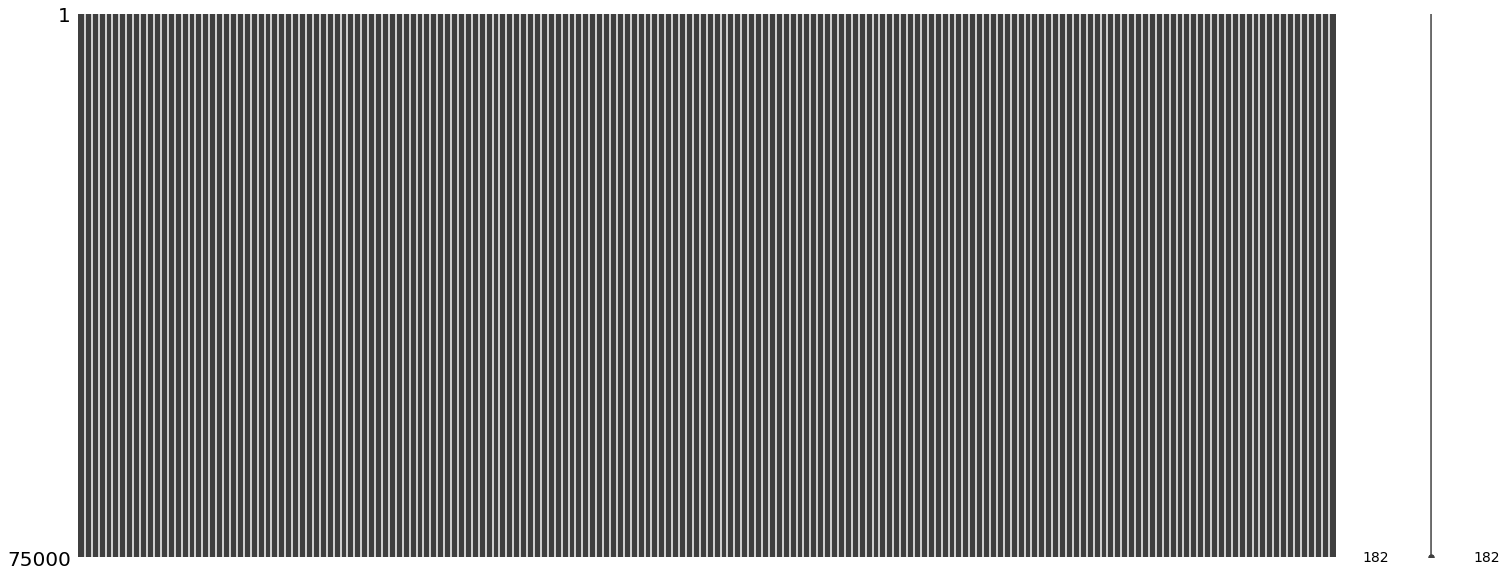

In [24]:
msno.matrix(test_crop)

In [25]:
col_number_view = 20
for it in range(math.ceil(train_crop.shape[1]/col_number_view)):
    print(train_crop.iloc[:,it*col_number_view:(it+1)*col_number_view].head(5))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2 P_emaildomain   C1  \
0   -1.0  150.0    discover  142.0  credit  315.0   87.0                1.0   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0     gmail.com  1.0   
2  490.0  150.0        visa  166.0   debit  330.0   87.0   outlook.com  1.0   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0     yahoo.com  2.0   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0     gmail.com  1.0   

    C2   C3   C4   C5   C6  
0  1.0  0.0  0.0  0.0  1.0  
1  1

In [26]:
for cat_colname in object_features.columns:
    if len(object_features[cat_colname].unique()) < 20:
        print(str(cat_colname) + '\n\n' + str(object_features[cat_colname].unique()) + '\n\n')
        print(object_features.groupby(cat_colname)[cat_colname].count())
        print('*' * 100 + '\n')

ProductCD

['W' 'H' 'C' 'S' 'R']


ProductCD
C     4934
H     7450
R     3354
S     1464
W    32799
Name: ProductCD, dtype: int64
****************************************************************************************************

card4

['discover' 'mastercard' 'visa' 'american express' nan]


card4
american express     1083
discover              654
mastercard          15696
visa                32562
Name: card4, dtype: int64
****************************************************************************************************

card6

['credit' 'debit' nan 'debit or credit' 'charge card']


card6
charge card            3
credit             15786
debit              34206
debit or credit        3
Name: card6, dtype: int64
****************************************************************************************************



In [27]:
map_ProductCD = {
    'W': 1,
    'H': 2,
    'C': 3,
    'S': 4,
    'R': 5
}
train_crop["ProductCD"] = train_crop["ProductCD"].map(map_ProductCD)
test_crop["ProductCD"] = test_crop["ProductCD"].map(map_ProductCD)

In [28]:
map_card4 = {
    'discover': 1,
    'mastercard': 2,
    'visa': 3,
    'american express': 4,
    '': -1
}
train_crop["card4"] = train_crop["card4"].map(map_card4)
test_crop["card4"] = test_crop["card4"].map(map_card4)

In [29]:
map_card6 = {
    'credit': 1,
    'debit': 2,
    'debit or credit': 3,
    'charge card': 4,
    '': -1
}
train_crop["card6"] = train_crop["card6"].map(map_card6)
test_crop["card6"] = test_crop["card6"].map(map_card6)

In [30]:
train_crop.drop(['P_emaildomain'], axis=1, inplace=True)
test_crop.drop(['P_emaildomain'], axis=1, inplace=True)

In [31]:
import datetime
timestamp = 1301990622 # timestamp, из которого переводим
print(datetime.datetime.fromtimestamp(timestamp))

2011-04-05 11:03:42


In [32]:
train_crop['TransactionDT']

0          86400
1          86401
2          86469
3          86499
4          86506
          ...   
49996    1189295
49997    1189302
49998    1189311
49999    1189336
50000    1189349
Name: TransactionDT, Length: 50001, dtype: int64

In [33]:
print(datetime.datetime.fromtimestamp(86400))
print(datetime.datetime.fromtimestamp(1189349))

1970-01-02 03:00:00
1970-01-14 21:22:29


In [34]:
# list(map(lambda x: datetime.datetime.fromtimestamp(x), train_crop['TransactionDT']))

In [35]:
col_number_view = 20
for it in range(math.ceil(train_crop.shape[1]/col_number_view)):
    print(train_crop.iloc[:,it*col_number_view:(it+1)*col_number_view].head(5))

   TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  card1  \
0        2987000        0          86400            68.5          1  13926   
1        2987001        0          86401            29.0          1   2755   
2        2987002        0          86469            59.0          1   4663   
3        2987003        0          86499            50.0          1  18132   
4        2987004        0          86506            50.0          2   4497   

   card2  card3  card4  card5  card6  addr1  addr2   C1   C2   C3   C4   C5  \
0   -1.0  150.0      1  142.0      1  315.0   87.0  1.0  1.0  0.0  0.0  0.0   
1  404.0  150.0      2  102.0      1  325.0   87.0  1.0  1.0  0.0  0.0  0.0   
2  490.0  150.0      3  166.0      2  330.0   87.0  1.0  1.0  0.0  0.0  0.0   
3  567.0  150.0      2  117.0      2  476.0   87.0  2.0  5.0  0.0  0.0  0.0   
4  514.0  150.0      2  102.0      1  420.0   87.0  1.0  1.0  0.0  0.0  0.0   

    C6   C7  
0  1.0  0.0  
1  1.0  0.0  
2  1.0  0.0  


In [36]:
train_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(7)
memory usage: 69.0 MB


In [37]:
test_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(7)
memory usage: 103.6 MB


### Задание №1

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

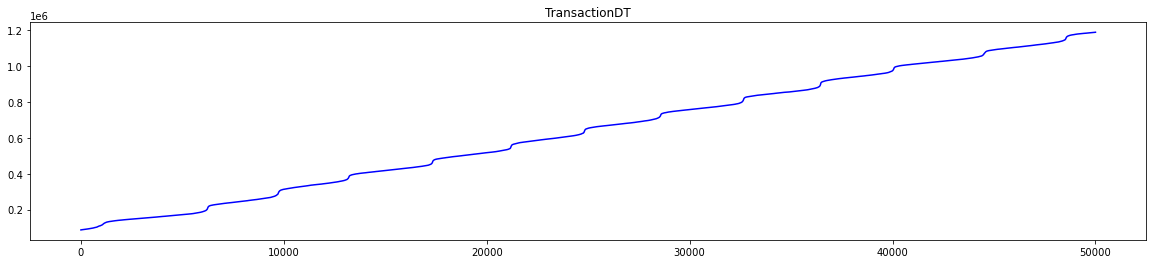

In [38]:
plt.figure(figsize =(20,4))
plt.plot(train_crop.index, train_crop['TransactionDT'], 'b')
plt.title('TransactionDT' )
plt.show()

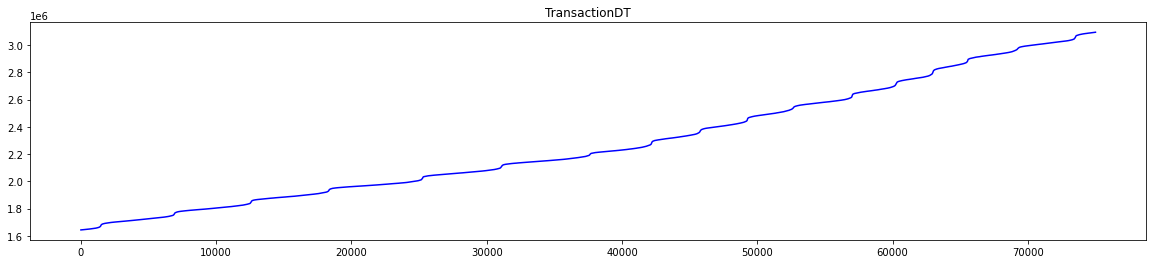

In [39]:
plt.figure(figsize =(20,4))
plt.plot(test_crop.index, test_crop['TransactionDT'], 'b')
plt.title('TransactionDT' )
plt.show()

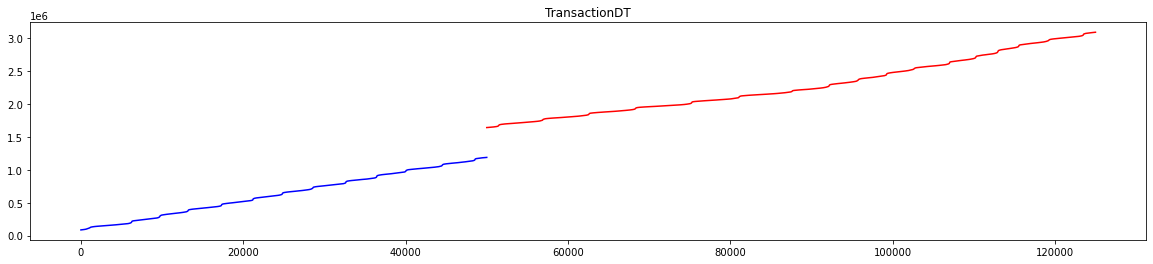

In [40]:
plt.figure(figsize =(20,4))
plt.plot(range(train_crop.shape[0]), train_crop['TransactionDT'], 'b')
plt.plot(range(train_crop.shape[0], train_crop.shape[0] + test_crop.shape[0]), test_crop['TransactionDT'], 'r')
plt.title('TransactionDT' )
plt.show()

#### Выводы:

1. Время представлено смещением в секундах от неизвестного начального момента
2. На train и на test разные непересекающиеся интервалы времени

### Задание №2

Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

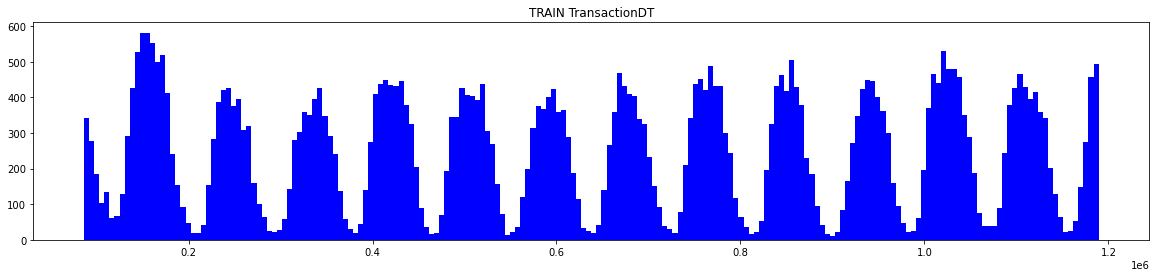

In [41]:
plt.figure(figsize =(20,4))
plt.hist(train_crop['TransactionDT'], bins=200, color="blue")
plt.title('TRAIN TransactionDT' )
plt.show()

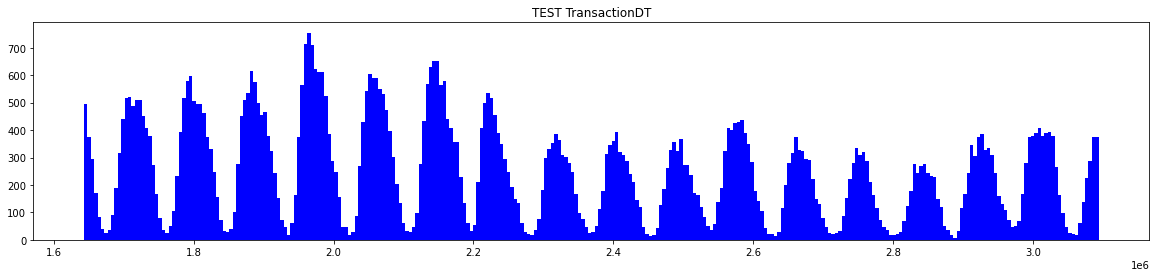

In [42]:
plt.figure(figsize =(20,4))
plt.hist(test_crop['TransactionDT'], bins=300, color="blue")
plt.title('TEST TransactionDT' )
plt.show()

In [43]:
train_fraud_0_DT = train_crop.loc[train_crop['isFraud'] == 0, 'TransactionDT'].copy()
train_fraud_0_DT.count()

48644

In [44]:
train_fraud_1_DT = train_crop.loc[train_crop['isFraud'] == 1, 'TransactionDT'].copy()
train_fraud_1_DT.count()

1357

In [45]:
test_fraud_0_DT = test_crop.loc[test_crop['isFraud'] == 0, 'TransactionDT'].copy()
test_fraud_0_DT.count()

73052

In [46]:
test_fraud_1_DT = test_crop.loc[test_crop['isFraud'] == 1, 'TransactionDT'].copy()
test_fraud_1_DT.count()

1948

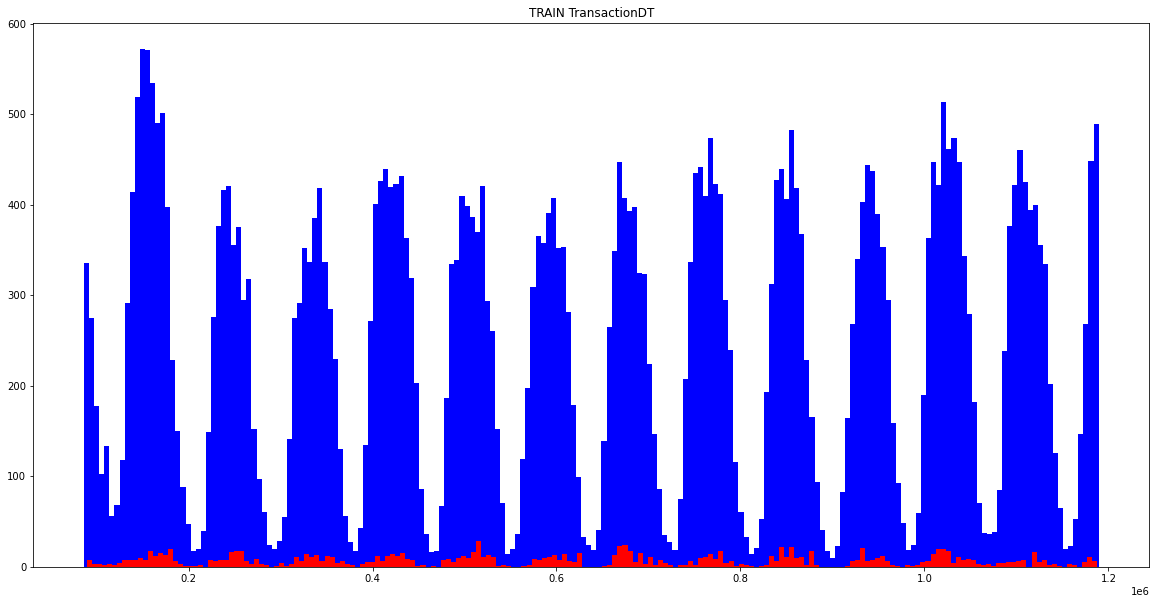

In [47]:
plt.figure(figsize =(20,10))
plt.hist(train_fraud_0_DT, bins=200, color="blue")
plt.hist(train_fraud_1_DT, bins=200, color="red")
plt.title('TRAIN TransactionDT' )
plt.show()

__Помним про то, что isFraud в test оставлен в учебных целях__

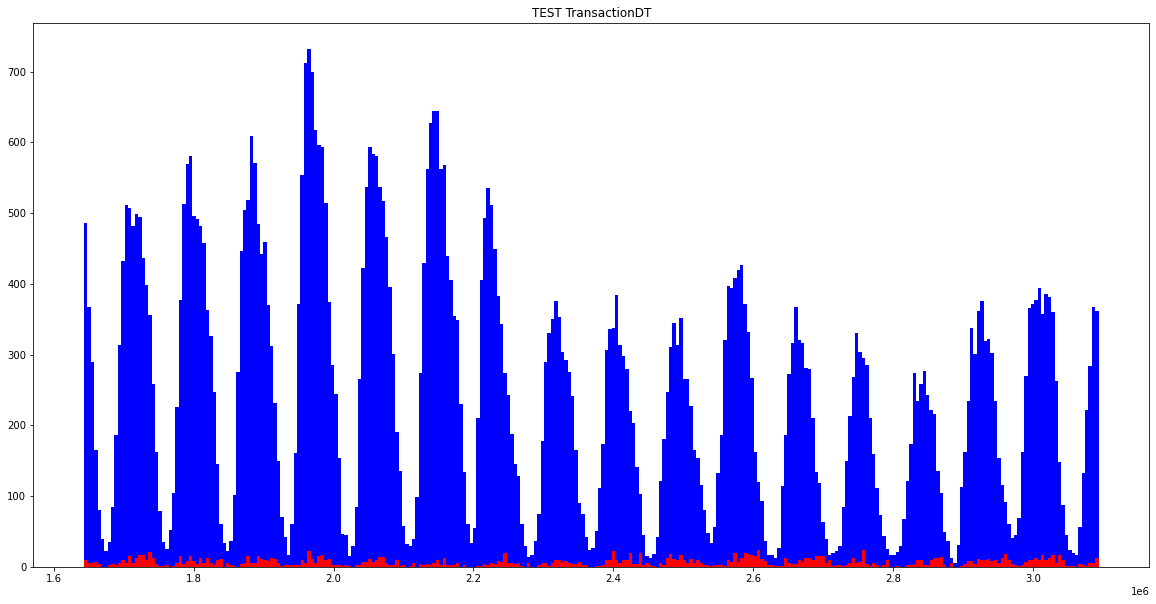

In [48]:
plt.figure(figsize =(20,10))
plt.hist(test_fraud_0_DT, bins=300, color="blue")
plt.hist(test_fraud_1_DT, bins=300, color="red")
plt.title('TEST TransactionDT' )
plt.show()

#### Выводы:

1. Выявлена предположительно суточная цикличность
2. Разные объёмы транзакций в циклах в пределах train и test и между train и test
3. Циклы fraud'а совпадают с циклами бъёмов

### Задание №3

Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

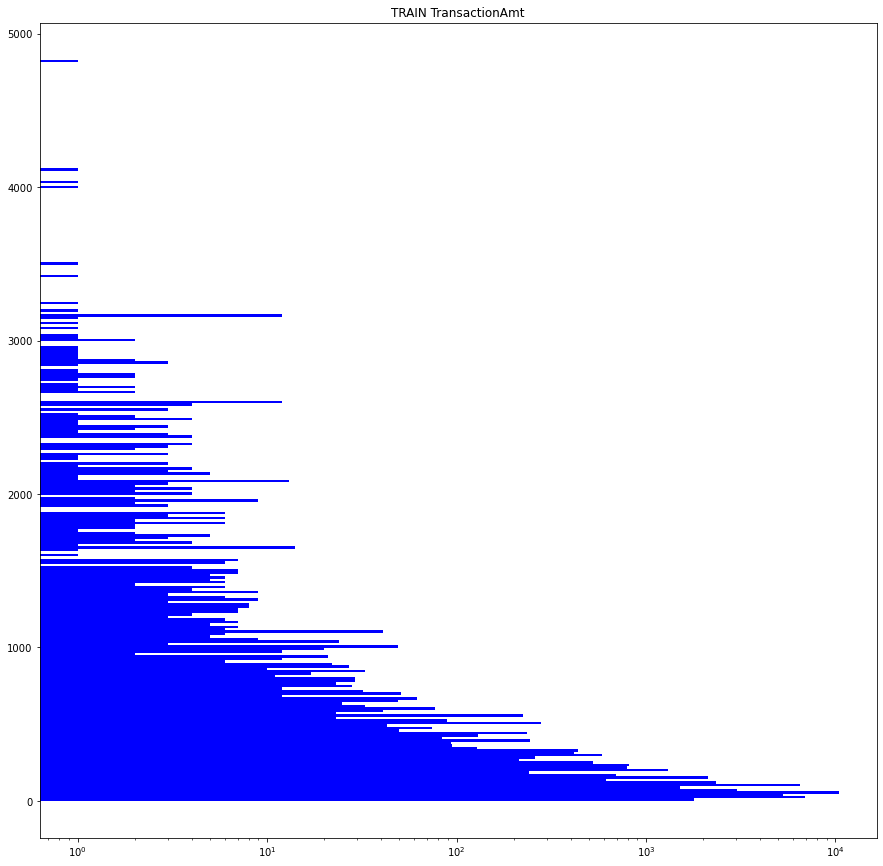

In [49]:
plt.figure(figsize =(15, 15))
plt.hist(train_crop['TransactionAmt'], bins=300, log=True, color="blue", orientation='horizontal')
plt.title('TRAIN TransactionAmt' )
plt.show()

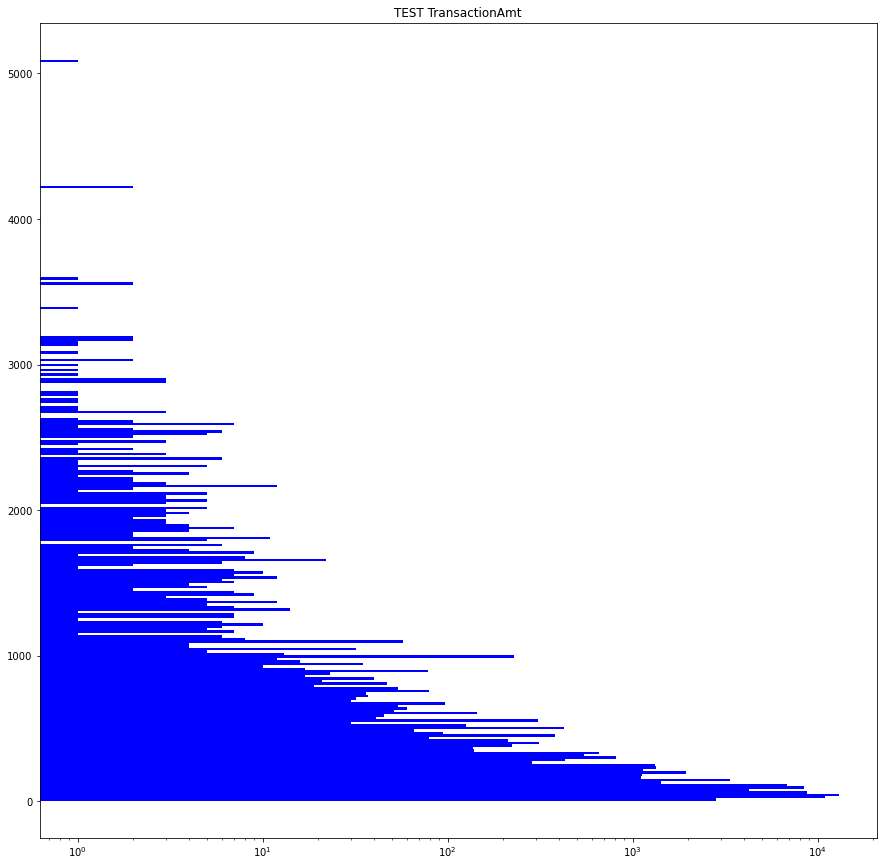

In [50]:
plt.figure(figsize=(15, 15))
plt.hist(test_crop['TransactionAmt'], bins=300, log=True, color="blue", orientation='horizontal')
plt.title('TEST TransactionAmt' )
plt.show()

In [51]:
train_fraud_0_TA = train_crop.loc[train_crop['isFraud'] == 0, 'TransactionAmt'].copy()
train_fraud_0_TA.count()

48644

In [52]:
train_fraud_1_TA = train_crop.loc[train_crop['isFraud'] == 1, 'TransactionAmt'].copy()
train_fraud_1_TA.count()

1357

In [53]:
test_fraud_0_TA = test_crop.loc[test_crop['isFraud'] == 0, 'TransactionAmt'].copy()
test_fraud_0_TA.count()

73052

In [54]:
test_fraud_1_TA = test_crop.loc[test_crop['isFraud'] == 1, 'TransactionAmt'].copy()
test_fraud_1_TA.count()

1948

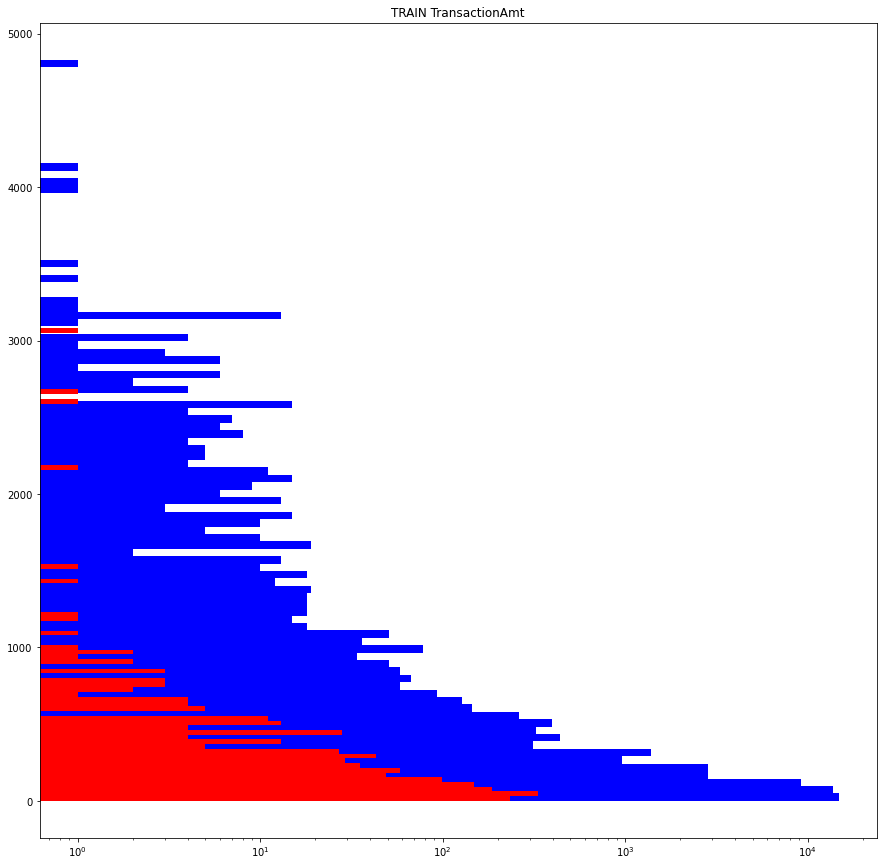

In [55]:
plt.figure(figsize =(15, 15))
plt.hist(train_fraud_0_TA, bins=100, log=True, color="blue", orientation='horizontal')
plt.hist(train_fraud_1_TA, bins=100, log=True, color="red", orientation='horizontal')
plt.title('TRAIN TransactionAmt' )
plt.show()

__Помним про то, что isFraud в test оставлен в учебных целях__

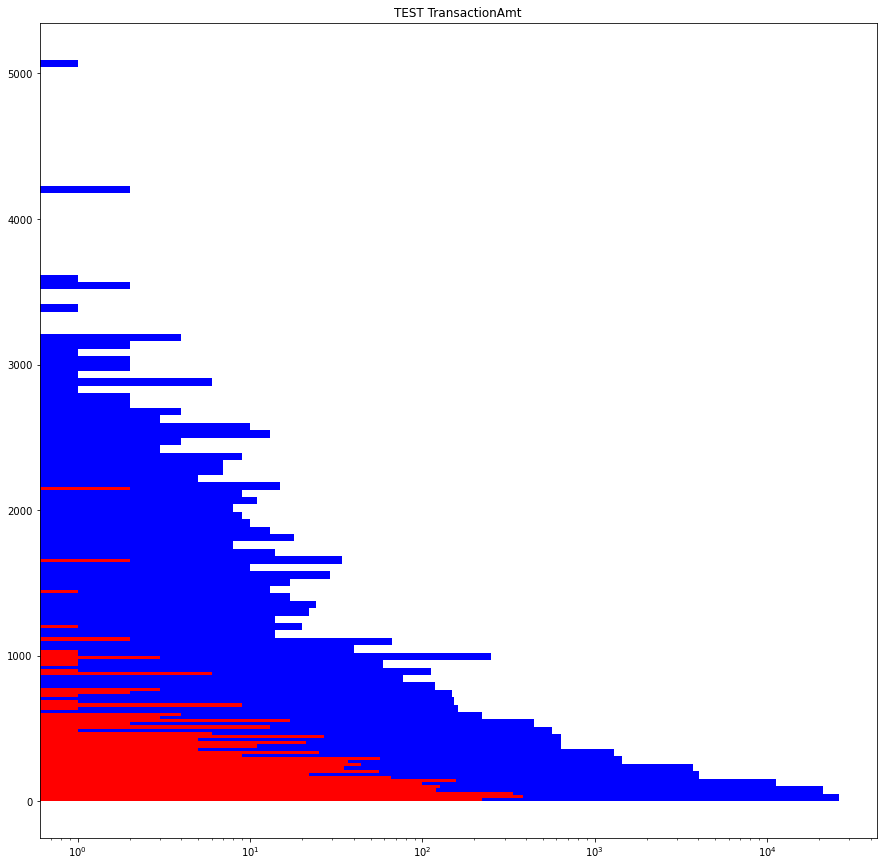

In [56]:
plt.figure(figsize =(15, 15))
plt.hist(test_fraud_0_TA, bins=100, log=True, color="blue", orientation='horizontal')
plt.hist(test_fraud_1_TA, bins=100, log=True, color="red", orientation='horizontal')
plt.title('TEST TransactionAmt' )
plt.show()

In [57]:
pd.set_option('display.max_rows', 1500)

In [58]:
train_fraud_1_TA.nunique()

374

In [188]:
train_fraud_1_TA.sort_values().head(30)

29976     0.292
41932     0.424
41962     0.424
42219     0.424
42265     0.424
47125     0.467
42215     0.467
31567     0.467
22794     0.467
47265     0.467
22733     0.467
20640     0.484
42304     1.590
38805     4.431
4763      5.000
48432     7.171
48451     7.171
23115     7.372
23110     7.372
34737     8.395
36123     8.512
31706     9.794
31699     9.794
28526    10.000
4797     10.000
780      10.000
3706     10.000
3704     10.000
3698     10.000
781      10.000
Name: TransactionAmt, dtype: float64

### Выводы
Выявлены суммы типичные для транзакций fraud

### Задание №4

Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [60]:
train[["ProductCD", "card4", "card6", "isFraud"]]

,ProductCD,card4,card6,isFraud
0,W,discover,credit,0
1,W,mastercard,credit,0
2,W,visa,debit,0
3,W,mastercard,debit,0
4,H,mastercard,credit,0
...,...,...,...,...
49996,R,visa,credit,0
49997,W,visa,credit,0
49998,C,mastercard,debit,0
49999,R,discover,credit,0


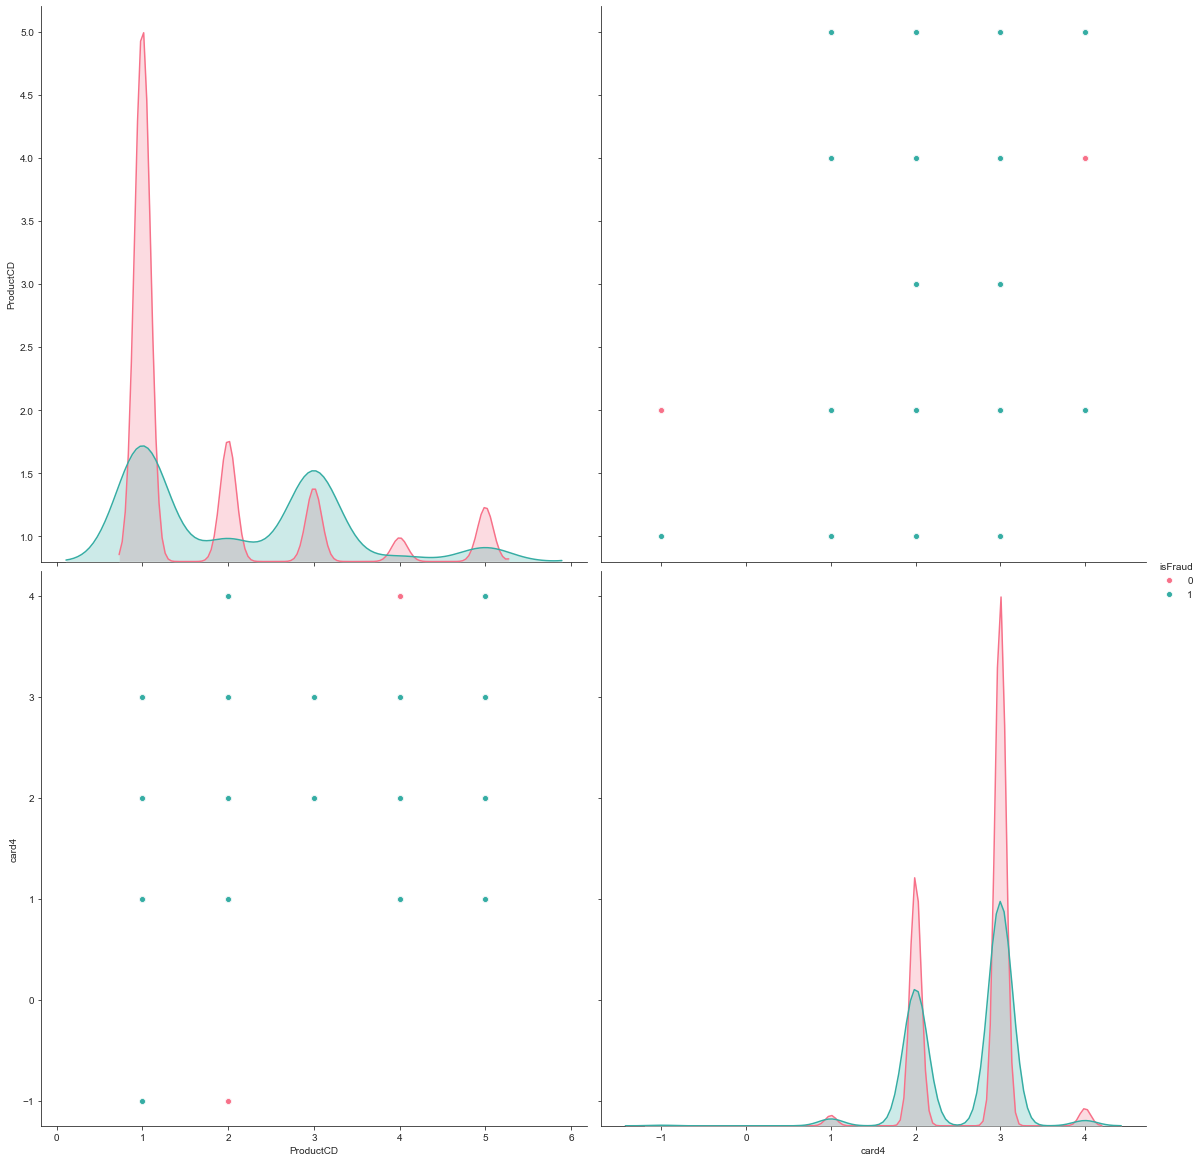

In [61]:
sns.set_style("ticks")
sns.pairplot(train_crop[["ProductCD", "card4", "isFraud"]],hue = "isFraud",diag_kind = "kde",kind = "scatter",palette = "husl", height=8)
plt.show()

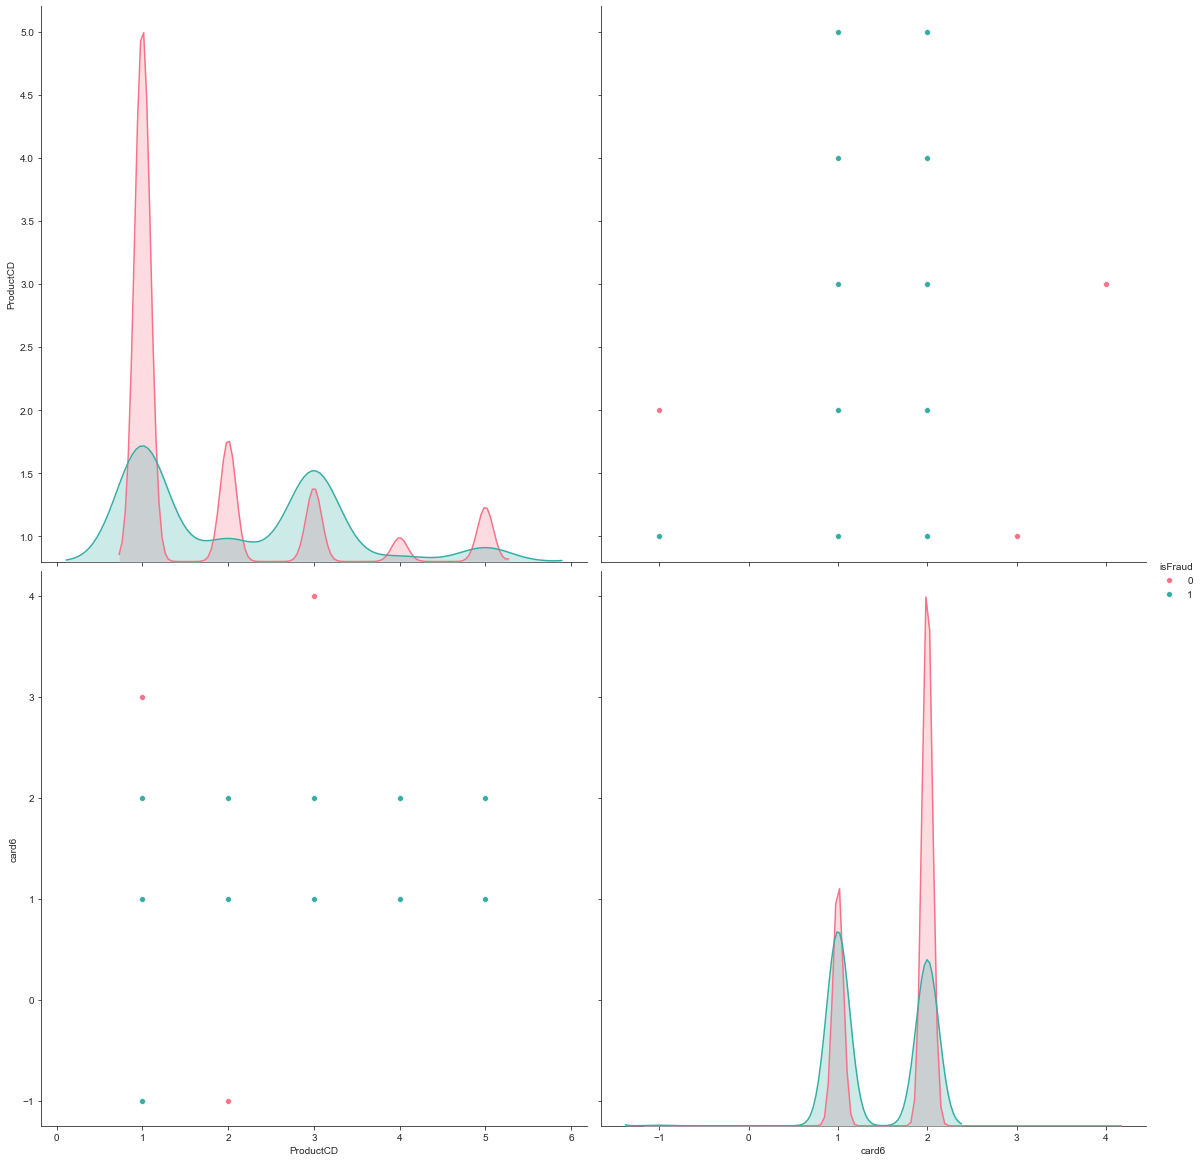

In [62]:
sns.set_style("ticks")
sns.pairplot(train_crop[["ProductCD", "card6", "isFraud"]],hue = "isFraud",diag_kind = "kde",kind = "scatter",palette = "husl", height=8)
plt.show()

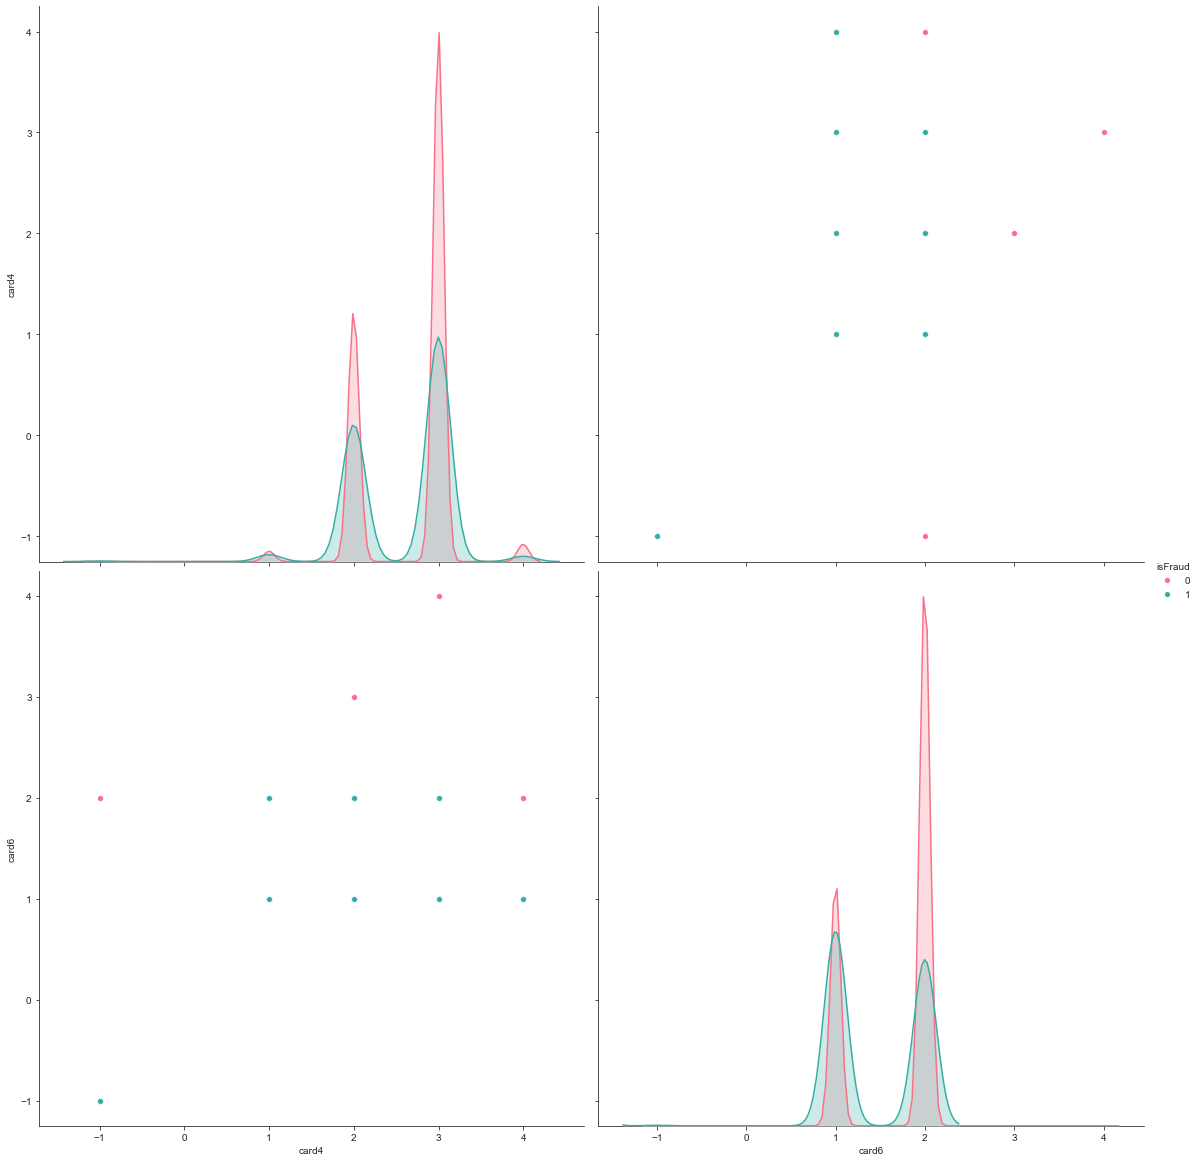

In [63]:
sns.set_style("ticks")
sns.pairplot(train_crop[["card4", "card6", "isFraud"]],hue = "isFraud",diag_kind = "kde",kind = "scatter",palette = "husl", height=8)
plt.show()

### Вывод:
Выявлены сочетания (малочисленные) принадлежащие только одному классу

## Модели

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание №1

Сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [124]:
x_train_1, x_test_1 = train_test_split(
    train_crop.drop(["isFraud", "TransactionID"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train_1, y_test_1 = train_test_split(
    train_crop["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

In [125]:
print("x_train_1.shape = {} rows, {} cols".format(*x_train_1.shape))
print("x_test_1.shape = {} rows, {} cols".format(*x_test_1.shape))

x_train_1.shape = 37500 rows, 179 cols
x_test_1.shape = 12501 rows, 179 cols


In [206]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.1
params["n_estimators"] = 200
params["random_state"] = 1
params["silent"] = 1
params["max_depth"] = 7
params["nthread"] = 4
params["eval_metric"] = "auc"
params["verbosity"] = 0

plst = list(params.items())

num_rounds=1000    

xgtrain_1 = xgb.DMatrix(x_train_1, label=y_train_1)
xgtst_1 = xgb.DMatrix(x_test_1, label=y_test_1)

watchlist  = [(xgtrain_1,'train'),(xgtst_1,'eval')]

model_1 = xgb.train(plst, 
                    xgtrain_1, 
                    num_rounds,
                    watchlist,
#                     feval='auc',
                    verbose_eval=False,
                    early_stopping_rounds=10)

print('best iter:',model_1.best_iteration)
print('best score:',model_1.best_score)

best iter: 105
best score: 0.921816


In [207]:
train_score = roc_auc_score(y_train_1, model_1.predict(xgtrain_1))
test_score = roc_auc_score(y_test_1, model_1.predict(xgtst_1))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.988, Test-score: 0.922


In [128]:
# xgb.plot_tree(model_1,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

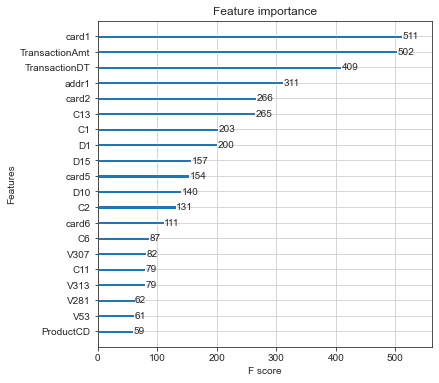

In [129]:
xgb.plot_importance(model_1, max_num_features=20)
# plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

__Поинтересуемся корреляцией с реальностью :)__

In [147]:
real_x, real_y = test_crop.drop(["isFraud", "TransactionID"], axis=1), test_crop["isFraud"]
xgreal = xgb.DMatrix(real_x, label=real_y)
print(f"REAL-score: {round(roc_auc_score(real_y, model_1.predict(xgreal)), 3)}")

REAL-score: 0.863


### Задание №2

Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [130]:
x_train_2, x_valid_2 = train_test_split(
    train_crop.drop(["isFraud", "TransactionID"], axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train_2, y_valid_2 = train_test_split(
    train_crop["isFraud"], train_size=0.7, shuffle=True, random_state=1,
)

x_valid_2, x_test_2 = train_test_split(
    x_valid_2, train_size=0.7, shuffle=True, random_state=27
)
y_valid_2, y_test_2 = train_test_split(
    y_valid_2, train_size=0.7, shuffle=True, random_state=27
)

print("x_train_2.shape = {} rows, {} cols".format(*x_train_2.shape))
print("x_valid_2.shape = {} rows, {} cols".format(*x_valid_2.shape))
print("x_test_2.shape = {} rows, {} cols".format(*x_test_2.shape))

x_train_2.shape = 35000 rows, 179 cols
x_valid_2.shape = 10500 rows, 179 cols
x_test_2.shape = 4501 rows, 179 cols


In [208]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.1
params["n_estimators"] = 200
params["random_state"] = 1
params["silent"] = 1
params["max_depth"] = 7
params["nthread"] = 4
params["eval_metric"] = "auc"
params["verbosity"] = 0

plst = list(params.items())

num_rounds=2000    

xgtrain_2 = xgb.DMatrix(x_train_2, label=y_train_2)
xgval_2 = xgb.DMatrix(x_valid_2, label=y_valid_2)
xgtst_2 = xgb.DMatrix(x_test_2, label=y_test_2)

watchlist  = [(xgtrain_2,'train'),(xgval_2,'eval')]

model_2 = xgb.train(plst, 
                    xgtrain_2, 
                    num_rounds,
                    watchlist,
#                     feval='auc',
                    verbose_eval=False,
                    early_stopping_rounds=10)

print('best ite:',model_2.best_iteration)
print('best score:',model_2.best_score)

best ite: 73
best score: 0.907358


In [209]:
train_score = roc_auc_score(y_train_2, model_2.predict(xgtrain_2))
valid_score = roc_auc_score(y_valid_2, model_2.predict(xgval_2))
test_score = roc_auc_score(y_test_2, model_2.predict(xgtst_2))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.982, Valid-score: 0.907, Test-score: 0.912


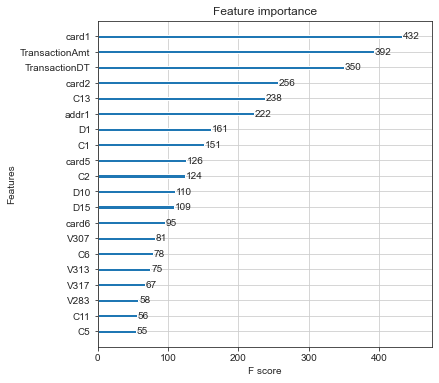

In [133]:
xgb.plot_importance(model_2, max_num_features=20)
# plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

__Поинтересуемся корреляцией с реальностью :)__

In [148]:
real_x, real_y = test_crop.drop(["isFraud", "TransactionID"], axis=1), test_crop["isFraud"]
xgreal = xgb.DMatrix(real_x, label=real_y)
print(f"REAL-score: {round(roc_auc_score(real_y, model_2.predict(xgreal)), 3)}")

REAL-score: 0.873


### Задание №3

Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [134]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test_1, model_1.predict(xgtst_1), roc_auc_score)

calculate_confidence_interval(scores)

(0.9015404843521512, 0.9406012089742235)

Text(0.5, 0, 'sample number')

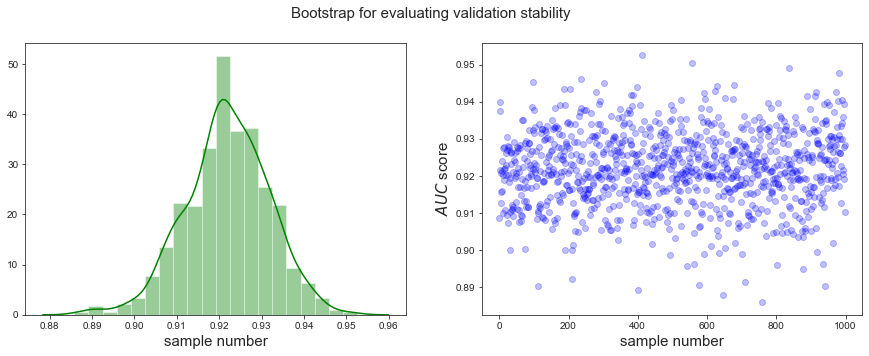

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$AUC$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

In [136]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test_2, model_2.predict(xgtst_2), roc_auc_score)

calculate_confidence_interval(scores)

(0.8793894366908834, 0.9430402675657611)

Text(0.5, 0, 'sample number')

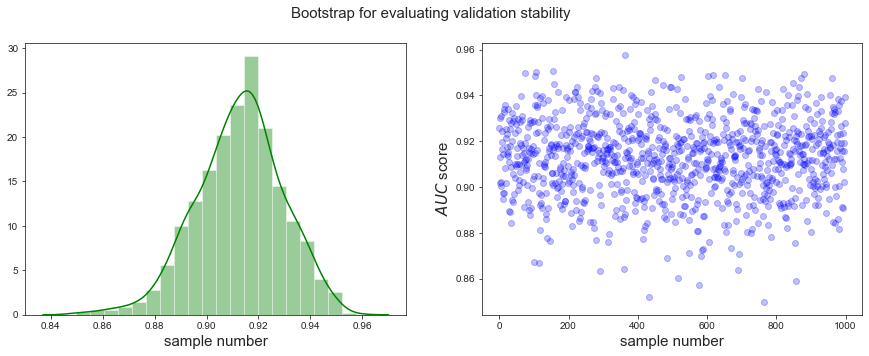

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$AUC$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

### Выводы
1. При разбиении на 3 подвыборки уменьшилась база обучения. 
2. Данные сильно неоднороны (дисбаланс классов, временная цикличность). 
3. Разбиение данных на большеечисло частей отрицательно сказалось на метрике и на разбросе.
4. Метрики на реальных данных: 0.863 для первого разбиения и 0.873 для второго

### Задание №4

Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объем из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [184]:
X_adv = pd.concat([
    train_crop.drop(['TransactionDT', "TransactionID"], axis=1), test_crop.drop(['TransactionDT', "TransactionID"], axis=1)
])
y_adv = np.hstack(
    (np.ones(train_crop.shape[0]), np.zeros(test_crop.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [185]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 4}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.7949
Wall time: 29.4 s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

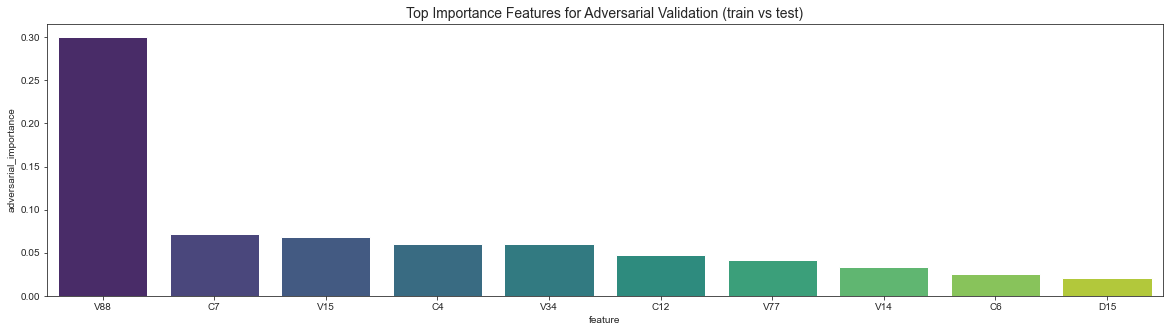

In [186]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

### Выводы

1. Высокое значение метрики при классификации train/test. Главный виновник: V88 (но и без этого параметра ранее отмечено: разные периоды времени, цикличность в данных, дисбаланс классов)
2. Данные разбиты неконсистентно!

### Задание №5

Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных.

In [175]:
def make_cross_validation_adapt(X: pd.DataFrame,
                                y: pd.Series,
                                params: Dict,
                                metric: callable,
                                cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    plst = list(params.items())

    num_rounds=1000 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        xgtrain = xgb.DMatrix(x_train, label=y_train)
        xgval = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(xgtrain,'train'), (xgval,'eval')]

        model = xgb.train(plst, 
                          xgtrain, 
                          num_rounds,
                          watchlist,
                          verbose_eval=False,
                          early_stopping_rounds=10)

        y_train_pred = model.predict(xgtrain)
        y_valid_pred = model.predict(xgval)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [176]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.1
params["n_estimators"] = 200
params["random_state"] = 1
params["silent"] = 1
params["max_depth"] = 7
params["nthread"] = 4
params["eval_metric"] = "auc"

In [178]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_adapt(
    train_crop.drop(['isFraud', "TransactionID"], axis=1),
    train_crop["isFraud"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9885, valid-score = 0.884
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9698, valid-score = 0.8823
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9782, valid-score = 0.9194
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9855, valid-score = 0.909
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9817, valid-score = 0.8944
CV-results train: 0.9807 +/- 0.006
CV-results valid: 0.8978 +/- 0.014
OOF-score = 0.8979


In [179]:
cv_strategy

KFold(n_splits=5, random_state=1, shuffle=False)

In [180]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_adapt(
    train_crop.drop(['isFraud', "TransactionID"], axis=1), 
    train_crop["isFraud"], 
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9778, valid-score = 0.8707
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9725, valid-score = 0.8792
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9724, valid-score = 0.9056
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9698, valid-score = 0.8316
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.953, valid-score = 0.8642
CV-results train: 0.9691 +/- 0.008
CV-results valid: 0.8702 +/- 0.024
OOF-score = 0.8556


С другим random_state(27)

In [181]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=27)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_adapt(
    train_crop.drop(['isFraud', "TransactionID"], axis=1), 
    train_crop["isFraud"], 
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9778, valid-score = 0.8707
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9725, valid-score = 0.8792
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9724, valid-score = 0.9056
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9698, valid-score = 0.8316
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.953, valid-score = 0.8642
CV-results train: 0.9691 +/- 0.008
CV-results valid: 0.8702 +/- 0.024
OOF-score = 0.8556


__:( При StratifiedKFold ухудшилась метрика и неожиданный поворот, random_state(StratifiedKFold) не влияет на результат!!!?__

In [182]:
cv_strategy = KFold(n_splits=10, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_adapt(
    train_crop.drop(['isFraud', "TransactionID"], axis=1),
    train_crop["isFraud"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 45000, valid-observations = 5001
train-score = 0.9827, valid-score = 0.8663
Fold: 2, train-observations = 45001, valid-observations = 5000
train-score = 0.987, valid-score = 0.9178
Fold: 3, train-observations = 45001, valid-observations = 5000
train-score = 0.9666, valid-score = 0.893
Fold: 4, train-observations = 45001, valid-observations = 5000
train-score = 0.9487, valid-score = 0.8754
Fold: 5, train-observations = 45001, valid-observations = 5000
train-score = 0.9797, valid-score = 0.9313
Fold: 6, train-observations = 45001, valid-observations = 5000
train-score = 0.98, valid-score = 0.9274
Fold: 7, train-observations = 45001, valid-observations = 5000
train-score = 0.9873, valid-score = 0.9061
Fold: 8, train-observations = 45001, valid-observations = 5000
train-score = 0.9678, valid-score = 0.9053
Fold: 9, train-observations = 45001, valid-observations = 5000
train-score = 0.9926, valid-score = 0.9414
Fold: 10, train-observations = 45001, valid-observ

In [183]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation_adapt(
    train_crop.drop(['isFraud', "TransactionID"], axis=1), 
    train_crop["isFraud"], 
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 45000, valid-observations = 5001
train-score = 0.9419, valid-score = 0.865
Fold: 2, train-observations = 45001, valid-observations = 5000
train-score = 0.9812, valid-score = 0.8876
Fold: 3, train-observations = 45001, valid-observations = 5000
train-score = 0.9676, valid-score = 0.8883
Fold: 4, train-observations = 45001, valid-observations = 5000
train-score = 0.973, valid-score = 0.8839
Fold: 5, train-observations = 45001, valid-observations = 5000
train-score = 0.9742, valid-score = 0.9122
Fold: 6, train-observations = 45001, valid-observations = 5000
train-score = 0.9819, valid-score = 0.921
Fold: 7, train-observations = 45001, valid-observations = 5000
train-score = 0.9676, valid-score = 0.8678
Fold: 8, train-observations = 45001, valid-observations = 5000
train-score = 0.9634, valid-score = 0.895
Fold: 9, train-observations = 45001, valid-observations = 5000
train-score = 0.9592, valid-score = 0.85
Fold: 10, train-observations = 45001, valid-observat

In [196]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.1
params["n_estimators"] = 200
params["random_state"] = 1
# params["silent"] = 1
params["max_depth"] = 7
params["nthread"] = 4
params["eval_metric"] = "auc"
# params["verbosity"] = 0

In [197]:
data_dmatrix = xgb.DMatrix(train_crop.drop(['isFraud', "TransactionID"], axis=1), label=train_crop["isFraud"])

In [198]:
cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=5,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    metrics="auc", 
                    as_pandas=True,
                    verbose_eval=False,
                    show_stdv=False,
                    seed=1)

In [205]:
cv_results.tail(20)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
223,0.995341,0.000633,0.933923,0.004322
224,0.995398,0.000652,0.933943,0.004338
225,0.995465,0.000628,0.934012,0.004276
226,0.995518,0.000634,0.934062,0.004329
227,0.995542,0.000642,0.934036,0.004412
228,0.995562,0.000643,0.934135,0.004466
229,0.995610,0.000641,0.934114,0.004490
230,0.995651,0.000680,0.934131,0.004540
231,0.995732,0.000693,0.934243,0.004594
232,0.995767,0.000698,0.934139,0.004593


In [200]:
cv_results.tail(1)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
242,0.996197,0.000671,0.934683,0.004901


А теперь stratified=True

In [201]:
cv_results_s = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=5,
                    stratified=True,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    metrics="auc", 
                    as_pandas=True,
                    verbose_eval=False,
                    show_stdv=False,
                    seed=1)

In [204]:
cv_results_s.tail(20)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
102,0.985118,0.001362,0.922291,0.010553
103,0.985345,0.001287,0.922233,0.010428
104,0.985594,0.001291,0.922474,0.010402
105,0.985767,0.001306,0.922723,0.010680
106,0.985893,0.001268,0.922729,0.010716
107,0.986009,0.001251,0.922786,0.010617
108,0.986128,0.001214,0.922888,0.010802
109,0.986273,0.001213,0.923040,0.010888
110,0.986456,0.001393,0.923169,0.010895
111,0.986681,0.001510,0.923369,0.011097


In [203]:
cv_results_s.tail(1)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
121,0.98795,0.001499,0.924239,0.01045


### Выводы
1. Разброс при использовании KFold небольшой (+/- 0.014 valid)
2. Применение кросс-валидации повышает стабильность при построении модели

### Задание №6 * (опциональное): 

Сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

### Задание №7 ** (совсем опциональное): 

В данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).